# **Identification des régions italiennes qui ont subis de plein fouet des séismes entre aout et novembre 2016**

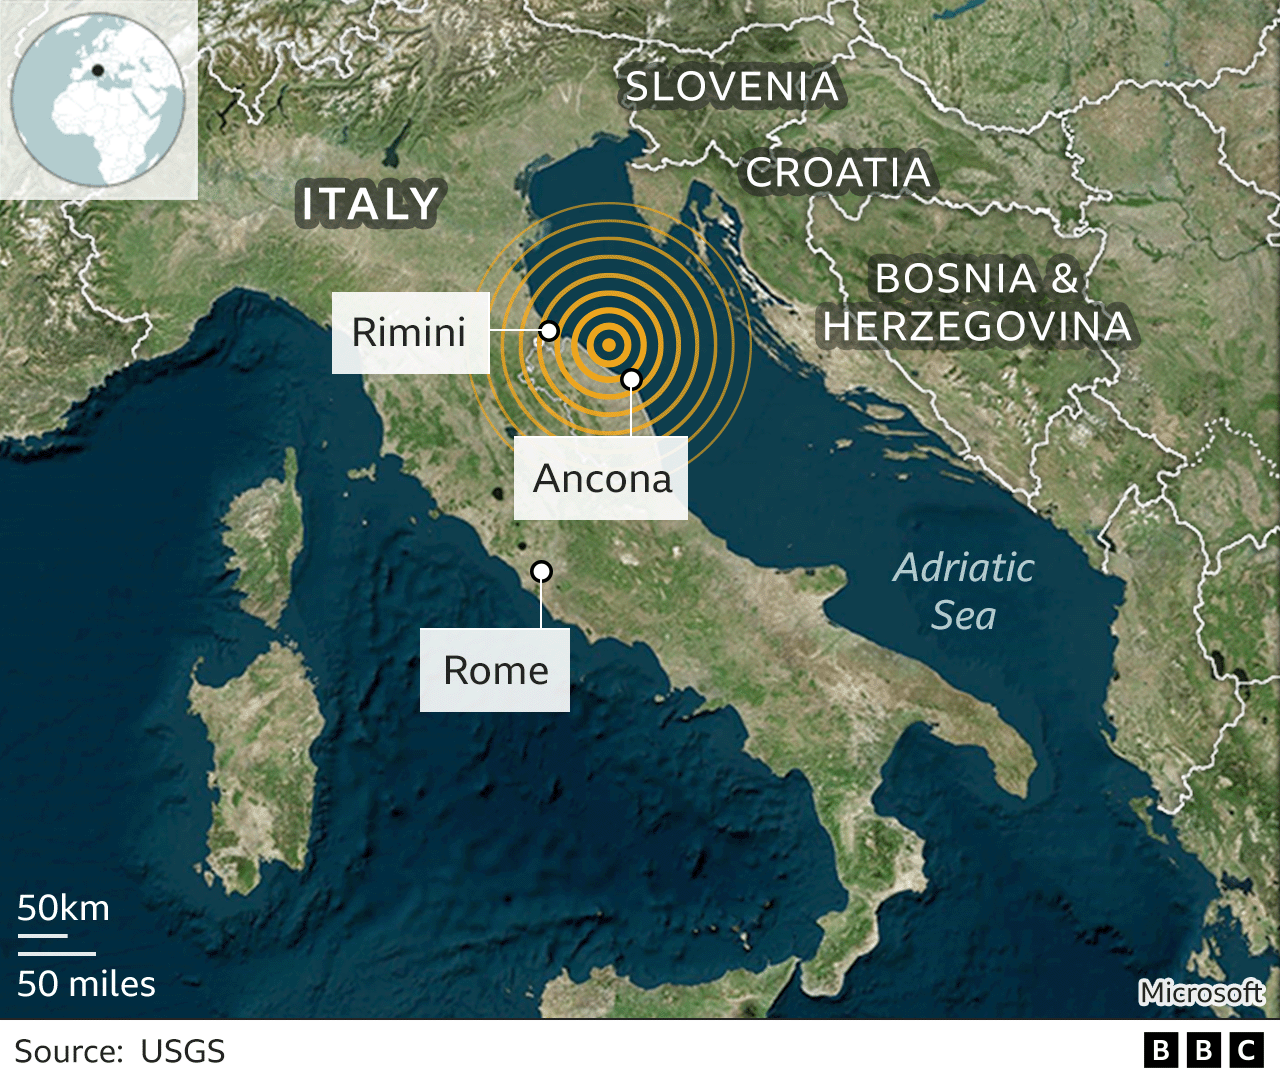

Dans le monde de la géologie, un évènement peu compris et peu prévisible fait de lourds déguats : les séismes.
Dans le cadre d'un aménagement durable, il est important de connaître les zones à risques pour mieux équiper les villes afin de diminuer l'impact des déguats.
C'est pour cette raison que cette cartographie est nécessaire.
Cette étude va se focaliser sur l'Italie, qui de part son contexte orogénique et son histoire géologique complexe, est une zone particulièrement sensible aux tremblements de terre.
Afin d'avoir une vision uniquement portée sur les séismes violents, l'étude se concentre sur les séismes dont l'amplitude est d'au moins 6.
La cartographie va alors permettre de mettre en avant les régions situées dans la zone d'impact de séismes dévastateurs.



In [ ]:
#import de fonction
!pip install mapclassify
!pip install fiona
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
!pip install folium --upgrade


In [36]:
# @title ETAPE 1 : pré-traitement de données

#L'objectif ici est de rendre utilisable les données pour le programme.
#Le fichier .csv étant très lourd, il convient de le nettoyer des séismes dont l'amplitude est inférieure à 6,1

#import du fichier csv
dataset=pd.read_csv('/content/italy_earthquakes_from_2016-08-24_to_2016-11-30.csv')
dataset.head()
#ici on créer un nouveau fichier avec uniquement les séismes dont l'amplitude est supérieur ou égal à 6,1
df = dataset[dataset["Magnitude"] >= 6]
df.head()
df.shape
column_names = df.columns
column_names

#Nous passons alors d'un csv à plus de 1 000 000 de lignes à seulement 1510...

Index(['Time', 'Latitude', 'Longitude', 'Depth/Km', 'Magnitude'], dtype='object')

In [38]:
# @title ETAPE 2 : import des données dans la carte
#Ici nous importons le fichier des villes d'Italie, puis nous importons depuis notre csv les sésimes

seismes = gpd.GeoDataFrame(df,
    geometry = gpd.points_from_xy(df['Longitude'], df['Latitude']),
    crs = 'EPSG:4326').to_file('/content/eq.shp')
#le fichier séismes est bien importé, au tour du fichier des villes

cities = gpd.read_file("/content/stanford-mn871sp9778-shapefile.zip")
cities.head()

#Pour des raisons de stabilité et surtout de temps de traitement l'étude se focalise sur les régions et non les villes, la méthode est la même, le résultat est juste plus rapide à charger
#tout fonctionne, étape suivante !

,id_0,iso,name_0,id_1,name_1,id_2,name_2,hasc_2,ccn_2,cca_2,type_2,engtype_2,nl_name_2,varname_2,geometry
0,112.0,ITA,Italy,1.0,Abruzzo,1.0,Chieti,IT.CH,0.0,69,Provincia,Province,NaN,NaN,"POLYGON ((14.25403 42.44514, 14.25403 42.44486..."
1,112.0,ITA,Italy,1.0,Abruzzo,2.0,L'Aquila,IT.AQ,0.0,66,Provincia,Province,NaN,Aquila,"POLYGON ((13.40441 42.57731, 13.40542 42.57468..."
2,112.0,ITA,Italy,1.0,Abruzzo,3.0,Pescara,IT.PE,0.0,68,Provincia,Province,NaN,NaN,"POLYGON ((14.07483 42.54282, 14.07576 42.54278..."
3,112.0,ITA,Italy,1.0,Abruzzo,4.0,Teramo,IT.TE,0.0,67,Provincia,Province,NaN,NaN,"POLYGON ((13.91542 42.89561, 13.91542 42.89542..."
4,112.0,ITA,Italy,2.0,Apulia,5.0,Bari,IT.BB,0.0,72,Provincia,Province,NaN,NaN,"MULTIPOLYGON (((17.28370 40.77928, 17.28340 40..."


In [ ]:
# @title ETAPE 3 : visualisation des données importées

eqs = gpd.read_file("/content/eq.shp")
#eqs pour le diminutif de earthquakes
eqs = eqs.to_crs(3857) #on met le même système de coordonnées que la carte
m = eqs.explore(zoom_start=6,width=1000, height=500)
cities.explore(m=m)
m

In [ ]:
# @title ETAPE 4 : sélection de la zone d'impact

#ici l'objectif est de généré une zone tampon d'un rayon de 100km autour de l'épicentre


eqs_buffer = eqs.buffer(100000) #l'unité est en mètre
#print(seismes_buffer.crs) #on vérifie le système de coordonnées du fichier
eqs_buffer = eqs_buffer.to_crs(3857) #on change le système de coordonnées pour qu'il soit le même que celui de la carte
eqs_buffer.to_file("/content/buffer.shp") #on importe le nouveau fichier sinon ca marche pas
buf = gpd.read_file("/content/buffer.shp")
m = buf.explore(zoom_start=6,width=1000, height=500)
cities.explore(m=m)
m
#on peut alors observer sur la carte les zones d'impacts des séismes et les régions qui sont touchées, cependant, on veut afficher uniquement les régions touchées....

In [ ]:
# @title ETAPE 5 : sélection des villes situées dans les zones d'impact


#on cherche à réaliser un intersect   entre buf et cities, on les mets d'abord dans le meme système de coordonnées
villes = cities.to_crs(buf.crs)
#on met les deux fichiers dans le même système de coordonnées

boom = gpd.sjoin(villes, buf, how='inner', op='intersects').to_file("/content/final.shp")
carte = gpd.read_file("/content/final.shp")

carte.shape
#nous avons au final 23 régions touchées


In [43]:
# @title ETAPE 6 : affichage des régions, des séismes et des zones d'impacts

from folium import plugins


m= carte.explore(column = "name_1",style_kwds=dict(color="black"), tooltip = "name_1", popup = True,name='Régions endommagées',zoom_start=7,width=1000, height=500)
buf.explore(m=m,style_kwds=dict(color="orange"),name='Zone de l impact')
eqs.explore(m=m, style_kwds=dict(color="red"), tooltip = "Magnitude", popup = True, name='Séismes à magnitude supérieur à 6')

minimap = plugins.MiniMap()
m.add_child(minimap)

folium.LayerControl().add_to(m)

m

In [ ]:
# @title ETAPE FINALE : import de la carte


from google.colab import files
m.save("Carte_Seismes_Italie.html")   #Le fichier est sauvegardé dans votre environnement Colab à gauche (icone dossier)
files.download("Carte_Seismes_Italie.html") # Téléchargez le fichier sur votre pc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>